In [1]:
import keras

from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Dense,Flatten,Dropout
from keras.models import Model,load_model
from keras.layers import Input,add,BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


C:\Users\Pradeep\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
checkpoint=ModelCheckpoint("weights-imporovement-{epoch:02d}-{val_acc:.2f}.hdf5",
                           monitor='val_loss',verbose=1,save_best_only=True,mode='max')

In [3]:
#EXTRACTING THE DATA FROM TAR FILE
num_classes=7

with open('fer2013.csv') as f:
    content=f.readlines()
lines=np.array(content)
nom=lines.size
Xtr, Ytr, Xte, Yte= [], [], [], []
for i in range(1,nom):
    try:
        emotion,pixels,Usage =lines[i].split(",")
        val=pixels.split(" ")
        pixx=np.array(val,'float32')
        emotion=keras.utils.to_categorical(emotion,num_classes)
        
        if 'Training' in Usage:
            Ytr.append(emotion)
            Xtr.append(pixx)
        elif 'PrivateTest' in Usage:
            Yte.append(emotion)
            Xte.append(pixx)
    except:
        print('Over')
   

In [4]:
#PRE-PROCESSING THE DATA
Xtr=np.array(Xtr,'float32')/255.
Ytr=np.array(Ytr,'float32')/255.

Xte=np.array(Xte,'float32')/255.
Yte=np.array(Yte,'float32')/255.      
 
exp={0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}

Xtr=Xtr.reshape(Xtr.shape[0],48,48)
Xte=Xte.reshape(Xte.shape[0],48,48)


In [5]:
#DATA-AUGMENTATION
Xfl = Xtr[:, :, ::-1]  # simple slice to flip all images
Yfl=Ytr
X=np.concatenate((Xtr,Xfl),axis=0)
Y=np.concatenate((Ytr,Yfl),axis=0)

In [23]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,test_size=0.12,random_state=485)
print(Xtrain.shape,Xval.shape)

(50527, 48, 48) (6891, 48, 48)


surprise


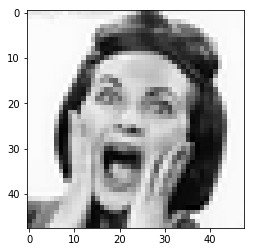

In [251]:
#LOOKING AT A RANDOM IMAGE AND ITS LABEL FROM THE TRAINING SET
k=np.random.randint(1,Xtrain.shape[0])       
plt.imshow(Xtrain[k].reshape(48,48),cmap='gray')
ar=np.argmax(Ytrain[k])
print(exp[ar])      


In [38]:
#RESHAPING THE IMAGES
Xtrain=Xtrain.reshape(Xtrain.shape[0],48,48,1)
Xval=Xval.reshape(Xval.shape[0],48,48,1)

In [165]:
#####DEFINING OUR MODEL USING THE KERAS FUNCTIONAL API
x=Input(shape=(48,48,1))
con1=Conv2D(8,(3,3),activation='relu')(x)
max1=MaxPooling2D( (2,2))(con1)
dr1=Dropout(0.05)(max1)
con2=Conv2D(16,(3,3),activation='relu')(dr1)
max2=MaxPooling2D((2,2))(con2)
con3=Conv2D(32,(3,3),activation='relu')(max2)
max3=MaxPooling2D((2,2))(con3)
flat=Flatten()(max3)
dens1=Dense(256,activation='relu')(flat)
ba=BatchNormalization(epsilon=0.0002)(dens1)
dens2=Dense(72,activation='relu')(ba)
op=Dense(7,activation='softmax')(dens2)

faces=Model(x,op)     

faces.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [166]:
faces.summary()
esm=EarlyStopping(monitor='val_loss',patience=3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 8)         80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 20)        1460      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          5792      
__________

In [167]:
Hist=faces.fit(Xtrain,Ytrain,batch_size=256,epochs=20,callbacks=[esm,checkpoint],validation_data=(Xval,Yval),
               shuffle=True)


Train on 50527 samples, validate on 6891 samples
Epoch 1/20
50527/50527 [==============================] - 22s 430us/step - loss: 0.0063 - acc: 0.3718 - val_loss: 0.0060 - val_acc: 0.4131

Epoch 00001: val_loss did not improve from 0.00655
Epoch 2/20
50527/50527 [==============================] - 21s 410us/step - loss: 0.0054 - acc: 0.4667 - val_loss: 0.0058 - val_acc: 0.4504

Epoch 00002: val_loss did not improve from 0.00655
Epoch 3/20
50527/50527 [==============================] - 21s 410us/step - loss: 0.0050 - acc: 0.5108 - val_loss: 0.0065 - val_acc: 0.3859

Epoch 00003: val_loss did not improve from 0.00655
Epoch 4/20
50527/50527 [==============================] - 21s 409us/step - loss: 0.0048 - acc: 0.5371 - val_loss: 0.0060 - val_acc: 0.4304

Epoch 00004: val_loss did not improve from 0.00655
Epoch 5/20
50527/50527 [==============================] - 21s 410us/step - loss: 0.0046 - acc: 0.5571 - val_loss: 0.0050 - val_acc: 0.5195

Epoch 00005: val_loss did not improve from 0.00

In [42]:
faces.save('newcnn.h5')

In [56]:
neww=load_model('newcnn.h5')

In [60]:
Xte=Xte.reshape(Xte.shape[0],48,48,1)
Xte.shape

(3589, 48, 48, 1)

The expected emotion is  surprise
The predicted emotion is  surprise


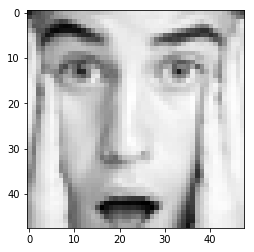

In [279]:
a=np.random.randint(1,Xte.shape[0])       
plt.imshow(Xte[a].reshape(48,48),cmap='gray')
print('The expected emotion is ',exp[np.argmax(Yte[a])])
testimage=np.expand_dims(Xte[a],axis=0)
pred=neww.predict(testimage)
print('The predicted emotion is ',exp[np.argmax(pred)])

#testimage.shape